**Importing Libraries**

In [ ]:
import csv
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as model_selection
from sklearn.model_selection import train_test_split

**Reading File**

In [ ]:
data_file = 'BNBUSDT_15m_data.csv'
data = pd.read_csv(data_file)

**Reading Columns**


In [ ]:
data.columns

**Data Setup**

In [ ]:
#Data for Keras

minute = pd.to_datetime(data['time']).dt.minute
hour = pd.to_datetime(data['time']).dt.hour
highPrice = pd.DataFrame(data['high'])
openPrice = pd.DataFrame(data['open'])
lowPrice = pd.DataFrame(data['low'])
closePrice = pd.DataFrame(data['close'])
#volBNB = pd.DataFrame(data['Vol BTT'])
#volUSDT = pd.DataFrame(data['Vol USDT'])
#trade = pd.DataFrame(data['trade'])


finalData = pd.concat([highPrice, lowPrice, closePrice, openPrice.shift(periods=-1)], axis=1)
#finalData = finalData.append(openPrice,)
#finalData.columns = ['low', 'close', 'open']
#finalData.index = pd.to_datetime(data['timestamp'][:-1])

highPrice = highPrice.shift(periods=-1)[:-2]
finalData = finalData[:-2]
finalData

,high,low,close,open
0,42.0000,41.6975,41.9617,41.9630
1,42.1557,41.7771,42.1475,42.1475
2,42.2798,41.9748,41.9857,41.9857
3,42.3332,41.9757,42.1276,42.1248
4,42.2164,41.9900,42.2163,42.2162
...,...,...,...,...
4646,239.7000,238.0000,238.5200,238.5200
4647,239.4999,237.7944,238.6965,238.7221
4648,238.7221,236.0000,236.3857,236.4042
4649,239.2000,236.3166,238.3492,238.3492


**Understanding Graph**

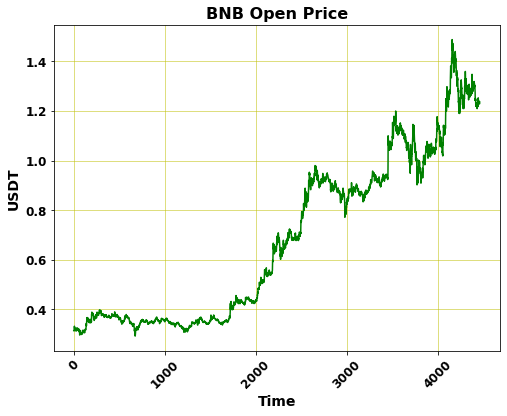

In [ ]:
#PreProcessing For Keras
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(8, 6))
plt.plot(highPrice[:highPrice.size-1], color='g')
plt.title('BNB Open Price', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('USDT', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)

**Finding Auto Corelation**

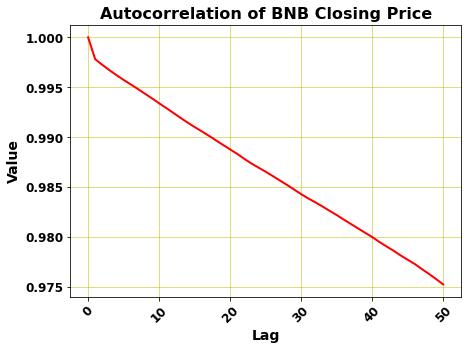

In [ ]:
#AutoCorelation

from statsmodels.tsa import stattools

acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(highPrice,
                                                             unbiased=True,
                                                             nlags=50,
                                                             qstat=True,
                                                             fft=True,
                                                             alpha = 0.05)

plt.figure(figsize=(7, 5))
plt.plot(pd.Series(acf_djia), color='r', linewidth=2)
plt.title('Autocorrelation of BNB Closing Price', weight='bold', fontsize=16)
plt.xlabel('Lag', weight='bold', fontsize=14)
plt.ylabel('Value', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)

In [ ]:
#Don't run it

#RegressAttribute Function
"""
def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :        
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['date'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['date'], drop=True, inplace=True)
    return df_copy
"""

In [ ]:
#Don't Run it
#Setting new Attribute for Keras
"""
list_of_attributes = ['open']

list_of_prev_t_instants = []
for i in range(1,25):
    list_of_prev_t_instants.append(i)

newData = create_regressor_attributes(openPrice, list_of_attributes, list_of_prev_t_instants)

newData.head()
"""

In [ ]:
#Function to setup time series data
#data is Panda DataFrame
#rowSize is the row needed to add
#it will return panda dataFrame with timeSeries inputData

def setUpTimeSeries(data, rowSize):
  row = []
  myDict = {}
  for i in range(data.size-rowSize+1):
      row = []
      for j in range(rowSize):
          row.append(data.iloc[i+j][0]) 
          myDict[i] = row

  finalData = pd.DataFrame.from_dict(myDict).transpose()
  return (finalData)

**Start From here by changing the value Required i.e OpenPrice, Low Price etc.**

In [ ]:
finalDataSingle = setUpTimeSeries(openPrice, 40)
finalDataSingle.tail()

**Layer Setup**

In [ ]:
#Deep Learning

from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model


#shape=19 for time series, shape=5 for other variables


input_layer = Input(shape=(3), dtype='float32')
dense1 = Dense(60, activation='linear')(input_layer)
dense2 = Dense(60, activation='linear')(dense1)
dense3 = Dense(60, activation="linear")(dense2)
dense4 = Dense(60, activation="linear")(dense3)
dropout_layer = Dropout(0.1)(dense4)
output_layer = Dense(1, activation='linear')(dropout_layer)


**Setting up Model**

In [ ]:
#Dense Model

denseModel = Model(inputs=input_layer, outputs=output_layer)
denseModel.compile(loss='mean_squared_error', optimizer='adam')
denseModel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 60)                240       
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 61    

**Dividing Train, Valid and Test Data**

In [ ]:
finalData

In [ ]:
finalDataSingle = finalData
lastLineLimit = finalDataSingle['low'].count()-1

size = finalDataSingle.columns.size
limit = size-1
y = highPrice.iloc[0:highPrice['high'].count()-1,:]
X = finalDataSingle.iloc[0:lastLineLimit, :]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=200, test_size=0.05)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.05, random_state=1)

X_test = pd.concat([X_test, finalDataSingle.iloc[lastLineLimit:, :]])
y_test = pd.concat([y_test, highPrice.iloc[highPrice['high'].count()-1:, :]])

#y_train = pd.DataFrame.squeeze(y_train)

#y_test = pd.DataFrame.squeeze(y_test)

y_test

,high
3248,172.8995
2115,67.0000
1300,42.2198
3507,292.6000
2297,67.1416
...,...
522,41.2709
1034,42.3549
4433,251.4264
3359,218.4864


In [ ]:
"""
#Don't use it
test_set_size = 0.06
valid_set_size= 0.02

#df_copy = finalData.reset_index(drop=True)
df_copy = finalDataSingle.reset_index(drop=True)

df_test = df_copy.iloc[ : int(np.floor(len(df_copy)*(test_set_size))) ]
df_train_plus_valid = df_copy.iloc[ int(np.floor(len(df_copy)*(test_set_size))) : ]

df_train = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(valid_set_size))) : ]
df_valid = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(valid_set_size))) ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]



print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)
"""

**Scaling Data**

In [ ]:
#dataScaling
"""
from sklearn.preprocessing import MinMaxScaler

Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
X_valid_scaled = Feature_scaler.fit_transform(np.array(X_valid))
X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_valid_scaled = Target_scaler.fit_transform(np.array(y_valid).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))
"""

 **Training**

In [ ]:
denseModel.fit(x=X_train, y=y_train, batch_size=256, epochs=1000, verbose=1, validation_data=(X_valid, y_valid), shuffle=True)
#denseModel.fit(x=X_train_scaled, y=y_train_scaled, batch_size=5, epochs=30, verbose=1, validation_data=(X_valid_scaled, y_valid_scaled), shuffle=True)


Epoch 1/1000
17/17 [==============================] - 1s 14ms/step - loss: 17108.4276 - val_loss: 2314.3777
Epoch 2/1000
17/17 [==============================] - 0s 4ms/step - loss: 1724.6094 - val_loss: 242.6254
Epoch 3/1000
17/17 [==============================] - 0s 4ms/step - loss: 395.0505 - val_loss: 6.8827
Epoch 4/1000
17/17 [==============================] - 0s 4ms/step - loss: 277.2921 - val_loss: 25.7570
Epoch 5/1000
17/17 [==============================] - 0s 4ms/step - loss: 235.8778 - val_loss: 19.0740
Epoch 6/1000
17/17 [==============================] - 0s 4ms/step - loss: 195.8392 - val_loss: 6.6998
Epoch 7/1000
17/17 [==============================] - 0s 4ms/step - loss: 156.5531 - val_loss: 7.1561
Epoch 8/1000
17/17 [==============================] - 0s 4ms/step - loss: 130.5574 - val_loss: 6.5755
Epoch 9/1000
17/17 [==============================] - 0s 4ms/step - loss: 105.4627 - val_loss: 5.6113
Epoch 10/1000
17/17 [==============================] - 0s 4ms/step - lo

**Rescaling Results**

**Calculating Accuracy**

In [ ]:
#Prediction
y_pred = denseModel.predict(X_test)

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance

y_test_rescaled = y_test
y_pred_rescaled = y_pred

r2score = r2_score(y_test, y_pred)

print('R-squared score for the test set:', round(r2score,4))
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print('Mear-squared Error for the test set:', mse)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print('Mean-Absolute Error for the test set:', mae)
print('Max Error: ', max_error(y_test_rescaled, y_pred_rescaled))



R-squared score for the test set: 0.9997
Mear-squared Error for the test set: 2.324174242703429
Mean-Absolute Error for the test set: 0.9680318726368444
Max Error:  6.030694580078148


**Individual Error Calculation**

In [ ]:
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual Open Price'])

y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted Open Price'])

org_arr = np.array(y_test_rescaled)
pre_arr = np.array(y_hat)

error = []
for i in range(0, y_actual.size):
  original = org_arr[i]
  predicted = pre_arr[i]
  error.append(((original-predicted)/original)*100)
  print(original, ": ", predicted, ", Error: ", error[i])

error.sort(reverse=True)

errorDF = pd.DataFrame(error)

#errorDF.iloc[380:]
print(errorDF.describe())

#print("Prediction for next candle: ", y_test_rescaled)

[172.8995] :  [175.471] , Error:  [-1.48727616]
[67.] :  [66.68643] , Error:  [0.46801211]
[42.2198] :  [42.343376] , Error:  [-0.29269717]
[292.6] :  [296.9601] , Error:  [-1.49012766]
[67.1416] :  [67.365616] , Error:  [-0.33364687]
[68.4091] :  [69.124596] , Error:  [-1.04590711]
[72.6999] :  [73.2269] , Error:  [-0.72489535]
[253.3617] :  [256.32095] , Error:  [-1.16799555]
[125.3587] :  [125.28182] , Error:  [0.06132625]
[50.1398] :  [50.59636] , Error:  [-0.91057255]
[40.8824] :  [41.02986] , Error:  [-0.36069666]
[129.807] :  [131.26578] , Error:  [-1.12380502]
[53.073] :  [53.290253] , Error:  [-0.40934691]
[70.8286] :  [71.46282] , Error:  [-0.89543202]
[39.8542] :  [40.0483] , Error:  [-0.48702946]
[51.6804] :  [51.76576] , Error:  [-0.16516613]
[40.9414] :  [40.957474] , Error:  [-0.03926039]
[315.9979] :  [312.53568] , Error:  [1.09564809]
[45.813] :  [46.09765] , Error:  [-0.62132718]
[40.2913] :  [40.551357] , Error:  [-0.64544274]
[170.9914] :  [171.51454] , Error:  [-0.

**Test Over Prediction Graph**

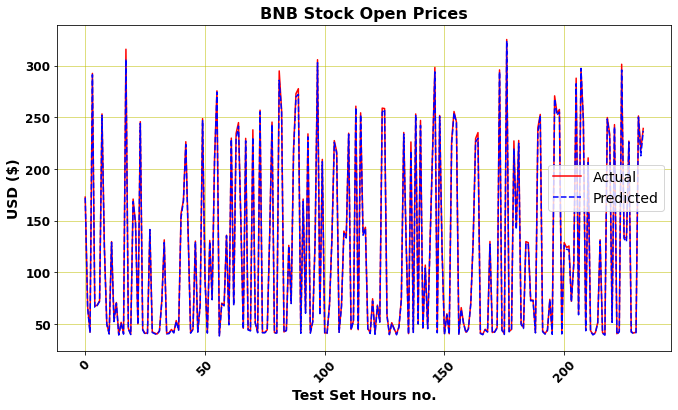

In [ ]:
plt.figure(figsize=(11, 6))
plt.plot(org_arr, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='b')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('BNB Stock Open Prices', weight='bold', fontsize=16)
plt.ylabel('USD ($)', weight='bold', fontsize=14)
plt.xlabel('Test Set Hours no.', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()

In [ ]:
openValue = 224.9470
lowValue = 222.0000
closeValue = 225.1176

newData = pd.DataFrame([[lowValue, closeValue, openValue]], columns = X_test.columns)

newPrediction = denseModel.predict(newData)

newPrediction[0][0]

228.36252

In [ ]:
import pickle

filename = 'highPriceModel'

denseModel.save(filename)

INFO:tensorflow:Assets written to: highPriceModel/assets
